***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


***

In [4]:
from copy import deepcopy
import gc
import dill
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from tqdm import tqdm
import yaml
import shap

from sklearn import preprocessing
import category_encoders as ce
import lightgbm as lgb
from tsforest.forecast import LightGBMForecaster

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor
from features import Featurador

In [5]:
SEED = 19
SUB_NBR = str(max([int(fn.split("/")[-1].split(".")[0][3:]) for fn in glob(f"{subs_path}/*")])+1)
print(SUB_NBR)

21


In [6]:
np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [7]:
with open(f"../data/skus_assess_m1.yaml", "r") as file:
    skus_assess_m1 = yaml.load(file, Loader=yaml.FullLoader)
    print(f"len(skus_assess_m1): {len(skus_assess_m1)}")
    file.close()

with open(f"../data/skus_assess_m2.yaml", "r") as file:
    skus_assess_m2 = yaml.load(file, Loader=yaml.FullLoader)
    print(f"len(skus_assess_m2): {len(skus_assess_m2)}")
    file.close()
    
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values
print(f"len(skus_for_test): {len(skus_for_test)}")

len(skus_assess_m1): 482635
len(skus_assess_m2): 272130
len(skus_for_test): 551472


In [8]:
if ASSESS:
    scales = pd.read_csv(f"{input_path}/scales.csv")
    
    #skus_assess_m1 = set(skus_assess_m1) & set(skus_for_test)
    #print("# skus assess & test:", len(skus_assess_m1))

    dataset = (
        pd.read_parquet(f"{input_path}/train-m1.parquet")
        .query("sku in @skus_assess_m1")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    
    with open("../encoders/encoder-stg1.dill", "rb") as file:
        encoder = dill.load(file)
        file.close()
    
    transformed = encoder.transform(dataset[encoder.cols].astype("category"))
    for col in transformed.columns:
        dataset[col+"_glm"] = transformed[col].values

In [9]:
if ASSESS:
    raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
    metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
    raw = pd.merge(raw, metadata, how="inner", on="sku")

    # compute q_mean and q_std features (w/o leakage)
    feat = Featurador(raw)
    feat.fit(left_limit="2021-02-01", right_limit="2021-03-01")
    dataset = feat.transform(dataset)

In [27]:
with open(f"../config/dist_hparams.yml", "r") as file:
    dist_config = yaml.load(file, Loader=yaml.FullLoader)
    file.close()

print(dist_config)

{'lambda1': 1.6842502030985615, 'lambda2': 0.3677507495760691, 'lambda3': 0.5635636515917665, 'lambda4': 0.022595175543313962}


In [12]:
# remove features built for the SM approach
dataset.drop([
    "item_domain_id_glob",
    "item_domain_id_glob_glm",
    "product_id_glob",
    "product_id_glob_glm",
    "product_family_id_glob",
    "product_family_id_glob_glm",
    ],
    axis=1,
    inplace=True
)

In [15]:
min_weight = 0.1
scaler = preprocessing.MinMaxScaler(feature_range=(min_weight, 1))
dataset["weight"] = scaler.fit_transform(dataset["minutes_active"].values.reshape(-1,1)).ravel()

***
## model config

In [16]:
categorical_features = {
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    "site_id":"default",
    "product_id": "default",
    "product_family_id": "default",
}

exclude_features = [
    "fold",
    "sold_quantity",
    "sku",
    "item_id",
    "minutes_active",
    "currency",
]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.02,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    #"lags": [1,],
    #"window_functions":{
    #    "mean":   (None, [1,], [3,7,]),
    #    "std":    (None, [1,], [3,7]),
    #},
}

***
## model training: assessment

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 109.60 Mb (48.4% reduction)
Mem. usage decreased to 114.20 Mb (48.4% reduction)
Elapsed time for processing features: 0.21632649501164755 min.
[LightGBM] [Info] Total Bins 10095
[LightGBM] [Info] Number of data points in the train set: 1209701, number of used features: 18
Training until validation scores don't improve for 30 rounds
[20]	valid_0's rmsse: 0.982846
[40]	valid_0's rmsse: 0.907148
[60]	valid_0's rmsse: 0.869384
[80]	valid_0's rmsse: 0.852213
[100]	valid_0's rmsse: 0.845301
[120]	valid_0's rmsse: 0.843479
[140]	valid_0's rmsse: 0.843791
Early stopping, best iteration is:
[123]	valid_0's rmsse: 0.843354


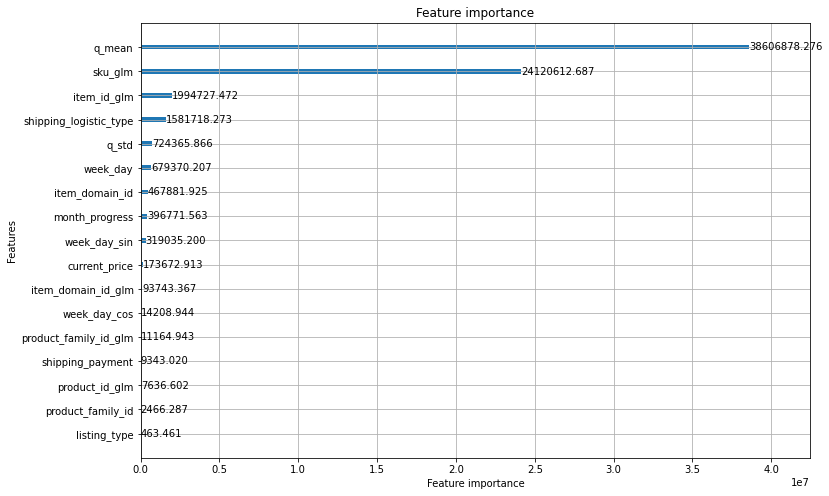

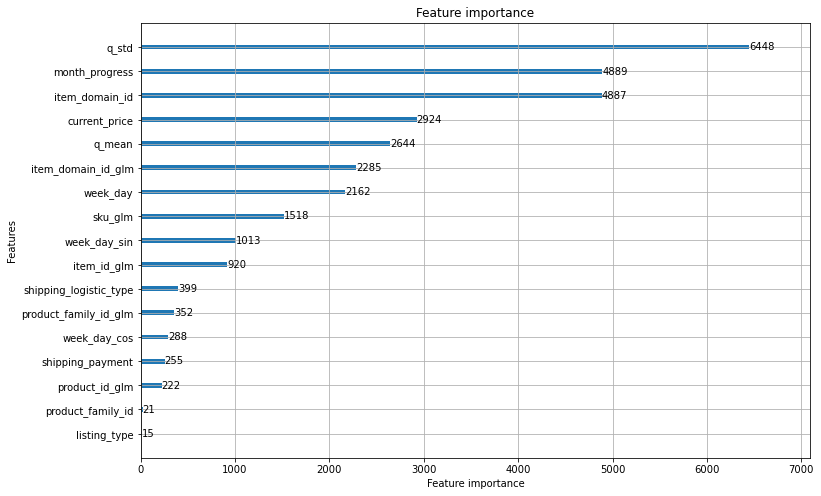

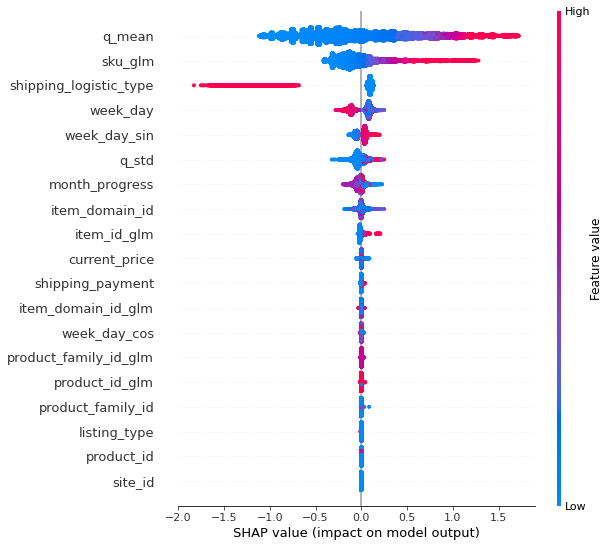

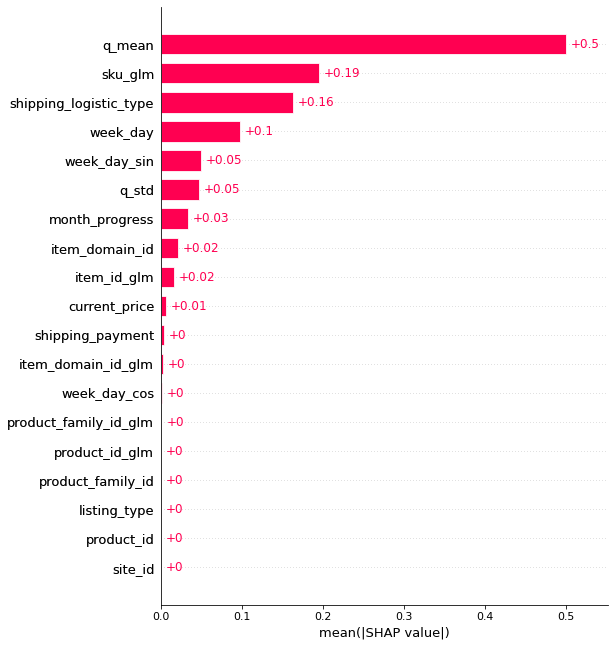

Elapsed time for training the model: 1.6786158243815104 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 640.18 Mb (48.4% reduction)
Mem. usage decreased to 666.02 Mb (48.4% reduction)
Elapsed time for processing features: 1.3307570417722066 min.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Total Bins 16750
[LightGBM] [Info] Number of data points in the train set: 7066070, number of used features: 18
Training until validation scores don't improve for 30 rounds
[20]	valid_0's rmsse: 1.04155
[40]	valid_0's rmsse: 0.964735
[60]	valid_0's rmsse: 0.926244
[80]	valid_0's rmsse: 0.90862
[100]	valid_0's rmsse: 0.901224
[120]	valid_0's rmsse: 0.898739
[140]	valid_0's rmsse: 0.898917
Early stopping, best iteration is:
[125]	valid_0's rmsse: 0.898534


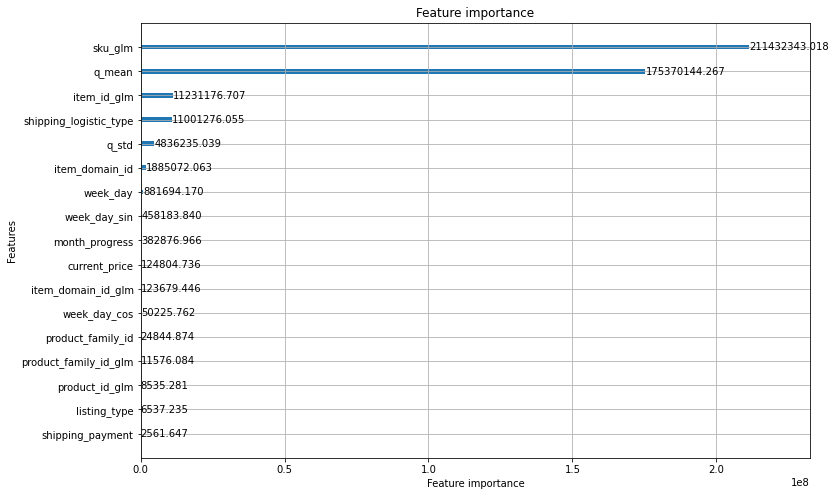

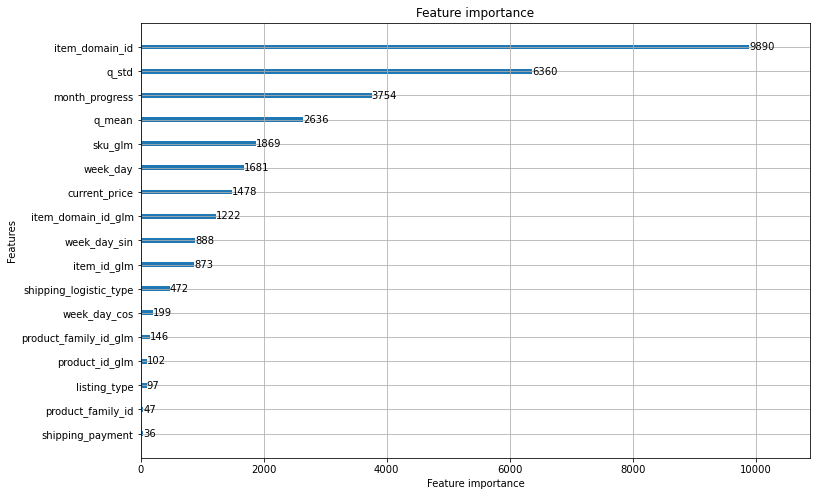

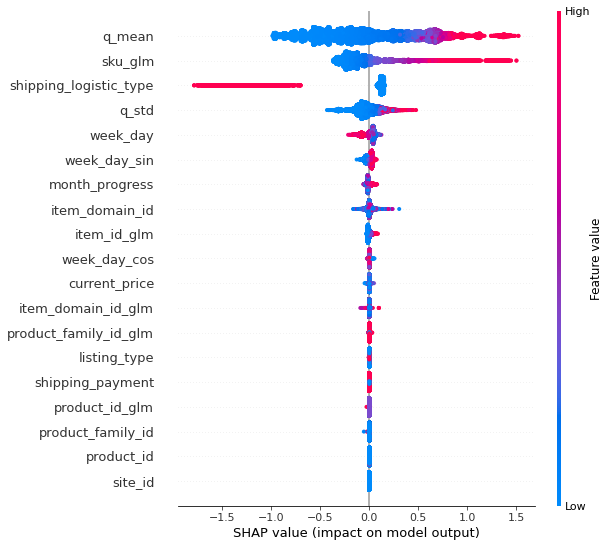

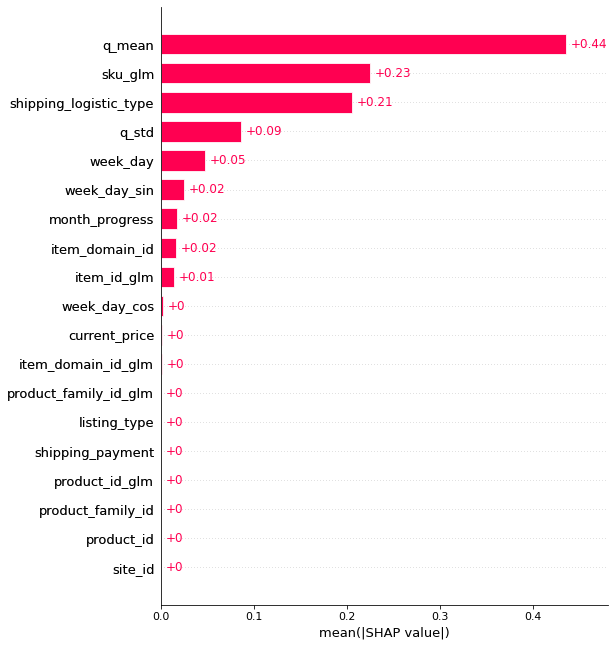

Elapsed time for training the model: 3.5260701100031535 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 508.99 Mb (48.4% reduction)
Mem. usage decreased to 531.57 Mb (48.4% reduction)
Elapsed time for processing features: 1.5971101721127827 min.
[LightGBM] [Info] Total Bins 14754
[LightGBM] [Info] Number of data points in the train set: 5618024, number of used features: 18
Training until validation scores don't improve for 30 rounds
[20]	valid_0's rmsse: 1.00164
[40]	valid_0's rmsse: 0.930838
[60]	valid_0's rmsse: 0.896935
[80]	valid_0's rmsse: 0.882927
[100]	valid_0's rmsse: 0.878656
[120]	valid_0's rmsse: 0.878704
[140]	valid_0's rmsse: 0.880842
Early stopping, best iteration is:
[111]	valid_0's rmsse: 0.878295


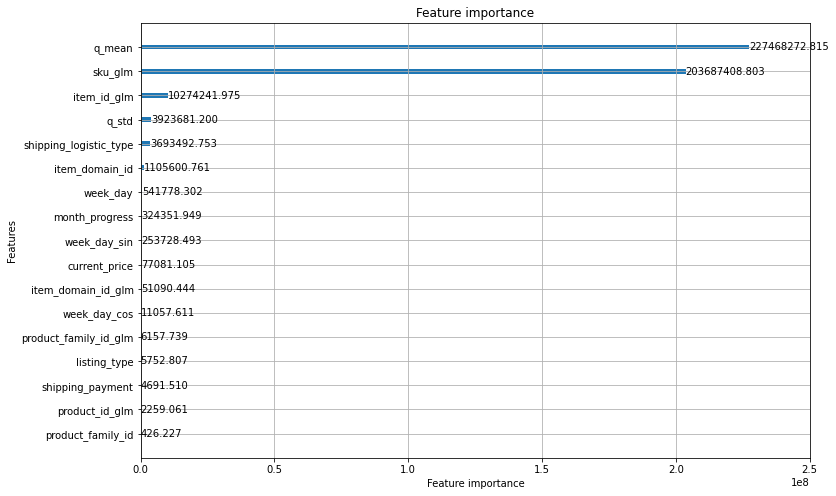

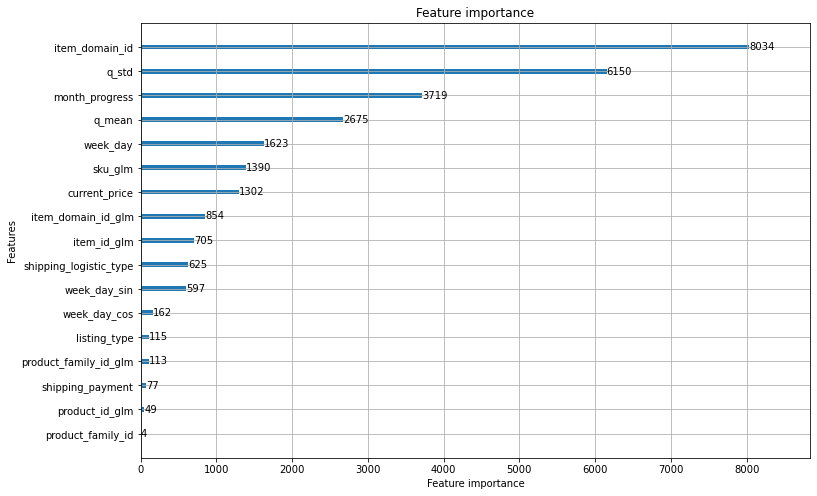

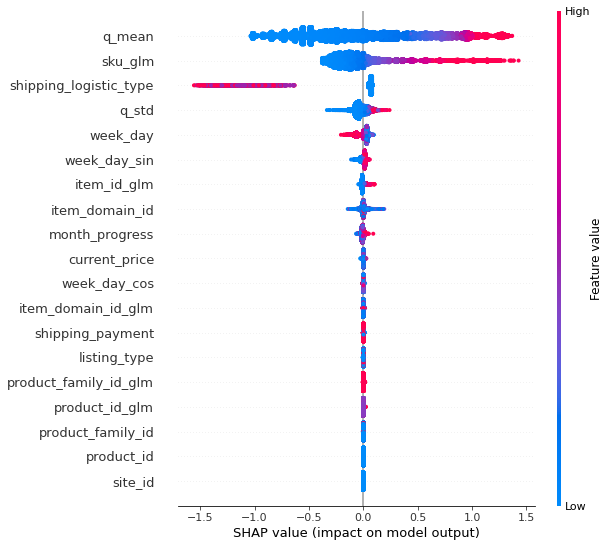

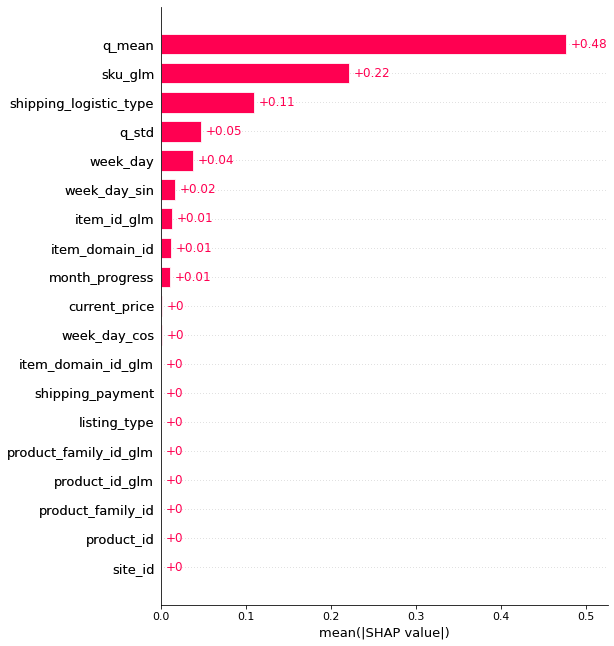

Elapsed time for training the model: 2.942700286706289 min.


{'rmsse_MLA': 0.8433542166268428,
 'rmsse_MLB': 0.8985339212927598,
 'rmsse_MLM': 0.8782951486167474,
 'rmsse_AVG': 0.87339442884545}

In [17]:
if ASSESS:
    models_by_site = list()
    sites = ["MLA","MLB","MLM"]

    for site in sites:
        print("-"*90)
        print(f"Preparing model for site: {site}")

        tic = time.time()
        train_data = dataset.query("site_id == @site").reset_index(drop=True)
        valid_idx = train_data.query("ds > '2021-03-01'").index

        model = LightGBMForecaster(**model_kwargs)
        model.prepare_features(train_data, valid_idx)
        model.train_features = reduce_mem_usage(model.train_features, verbose=True)
        model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
        gc.collect()
        tac = time.time()
        print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

        tic = time.time()
        evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
        model.fit(fit_kwargs={"verbose_eval":20, "feval":evaluator.evaluate})
        
        lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
        lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
        plt.show()
        explainer = shap.Explainer(model.model.model)
        shap_values = explainer(model.valid_features[model.input_features].sample(30000))
        shap.plots.beeswarm(shap_values, max_display=23, show=True)
        shap.plots.bar(shap_values, max_display=23, show=True)

        models_by_site.append(model)
        tac = time.time()
        print(f"Elapsed time for training the model: {(tac-tic)/60} min.")
        
    errors = list()
    sites = ["MLA","MLB","MLM"]
    for site,model in zip(sites,models_by_site):
        error = model.model.model.best_score["valid_0"]["rmsse"]
        errors.append(error)
    result = {
        "rmsse_MLA":errors[0], 
        "rmsse_MLB":errors[1],
        "rmsse_MLM":errors[2],
        "rmsse_AVG":np.mean(errors),
    }
    display(result)


In [18]:
%%time
if ASSESS:
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        print("Preds for site:", site)
        preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"), recursive=False)
        all_preds.append(preds)
    oof = pd.concat(all_preds, axis=0, ignore_index=True)

Preds for site: MLA
Preds for site: MLB
Preds for site: MLM
CPU times: user 3min 30s, sys: 12 s, total: 3min 42s
Wall time: 1min 18s


In [19]:
if ASSESS:
    mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
    valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
    valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
    display(valid_errors.groupby("site_id")["rmsse"].mean())

site_id
MLA    0.843354
MLB    0.898534
MLM    0.878295
Name: rmsse, dtype: float64

In [21]:
if ASSESS:
    oof.to_csv(f"{results_path}/oof_preds_lgbm-m1.csv", index=False)

***
## Assessment of invetory days prediction

In [22]:
if ASSESS:
    if "oof" not in locals():
        oof = pd.read_csv("../results/oof_preds_lgbm-m1.csv")
        
    predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"))
    predictor.fit(oof)

100%|██████████| 482635/482635 [01:18<00:00, 6122.92it/s]


In [23]:
if ASSESS:
    valid = (
        pd.read_csv(f"{input_path}/validation_seed2_harder.csv")
        .query("sku in @skus_assess_m1")
        .reset_index(drop=True)
    )

    preds = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
        
    valid["days_to_stockout"] = np.asarray(preds)
    valid["days_to_stockout_disc"] = valid["days_to_stockout"].astype(int)

100%|██████████| 482635/482635 [01:24<00:00, 5718.34it/s]


RMSE (mean):  9.66853042874965
MAE (mean):  7.1807069972416215
MAE (median):  5.1830048137407125



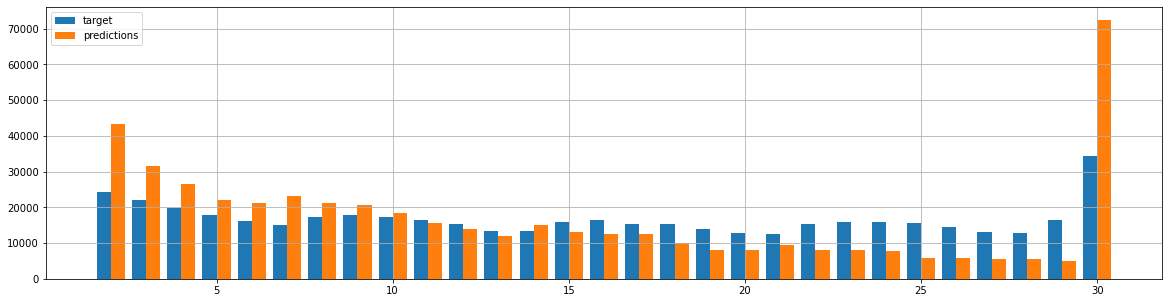

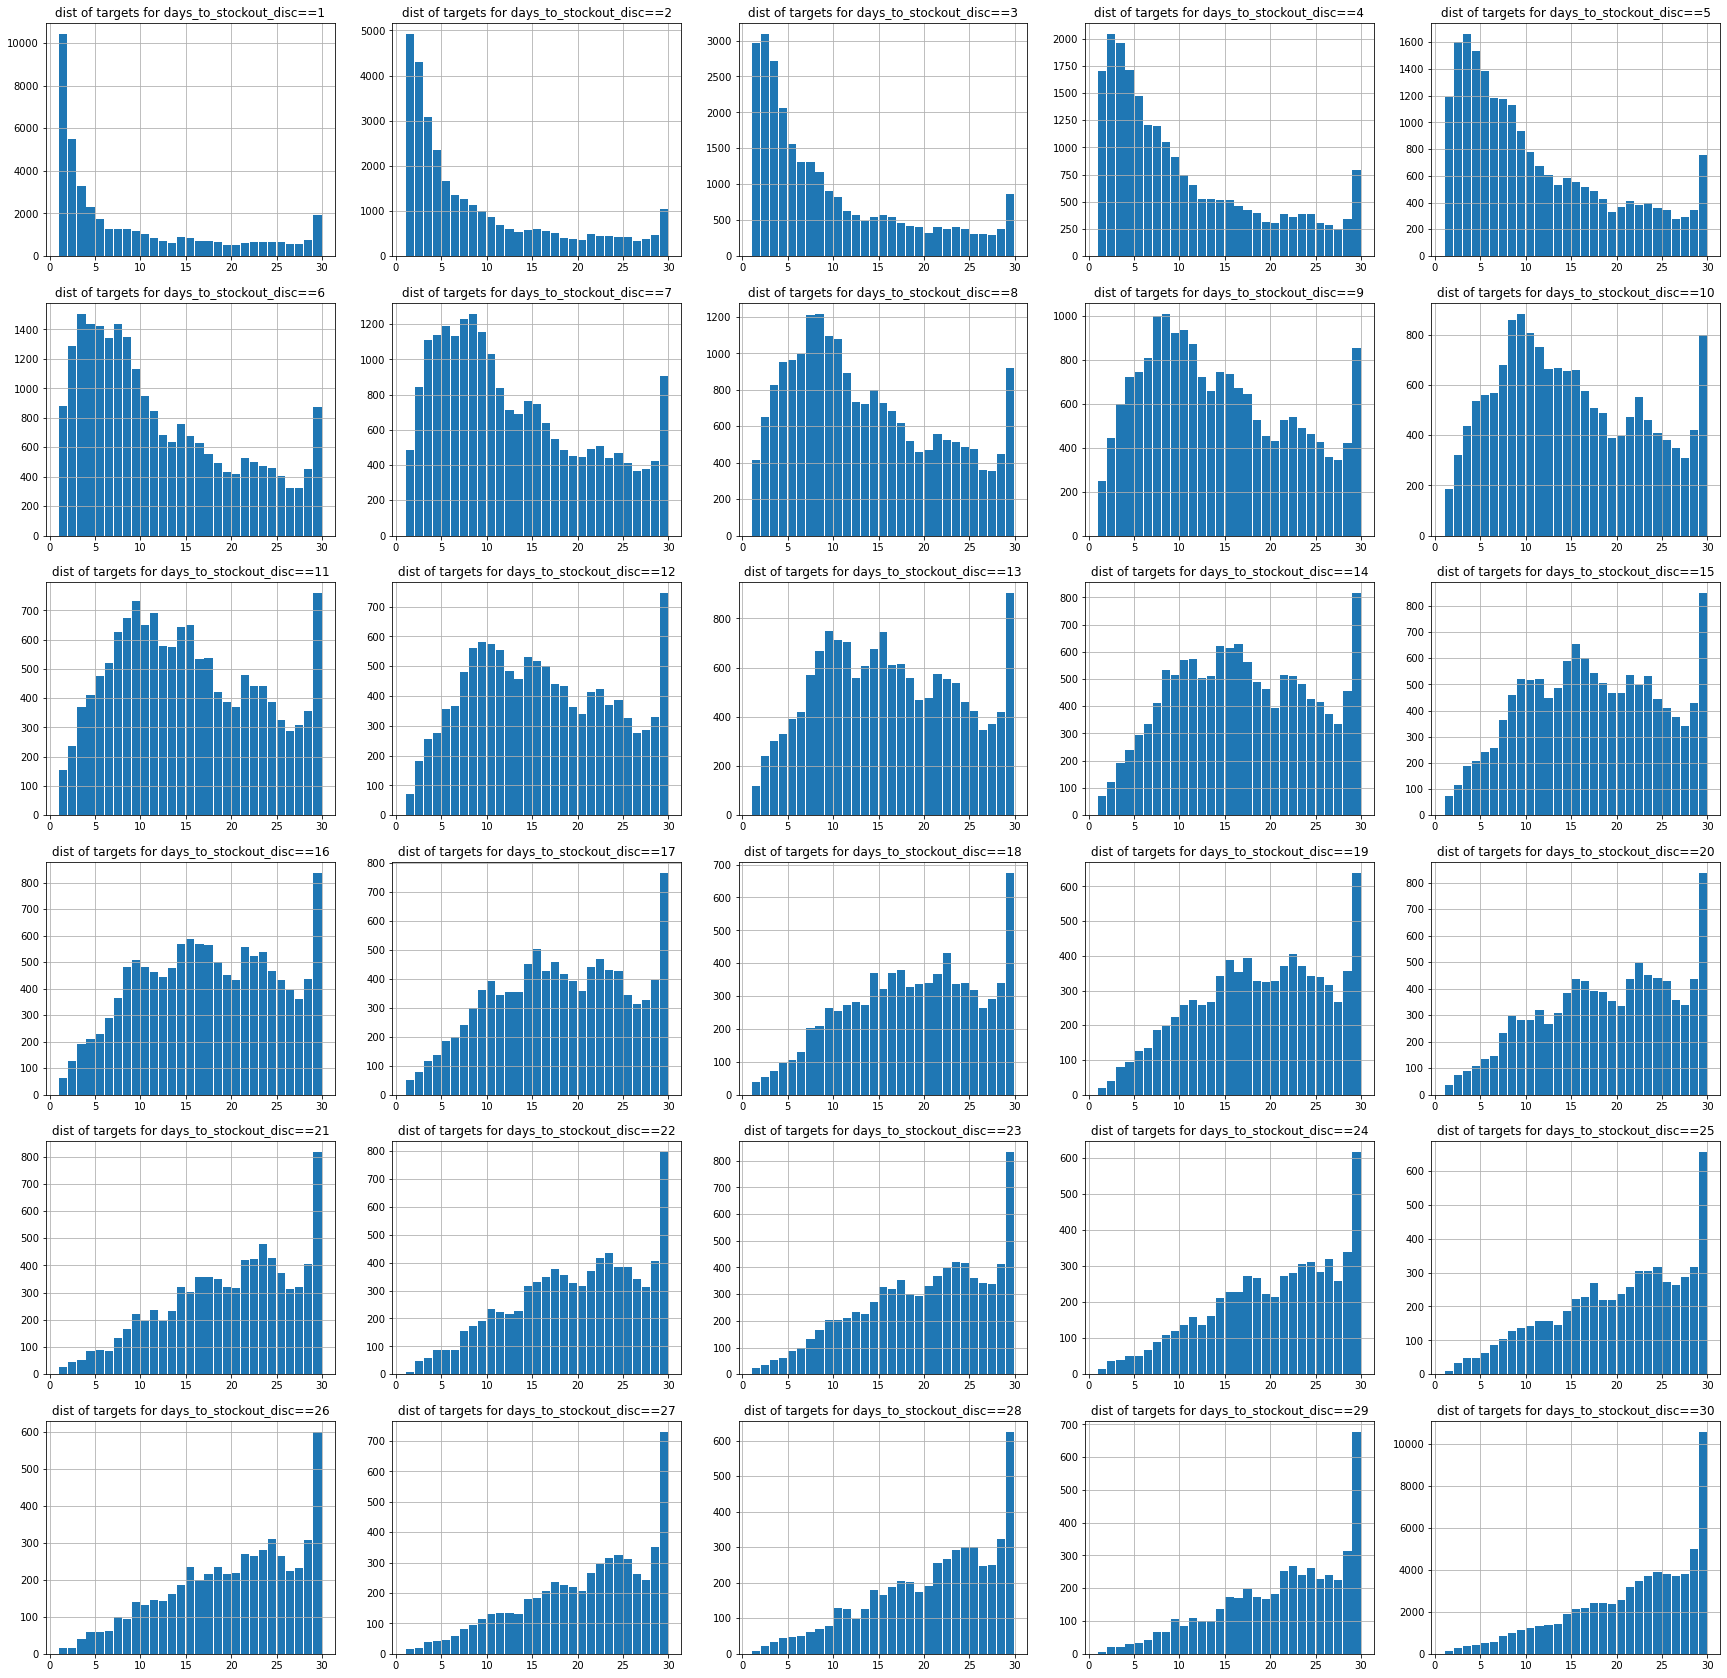

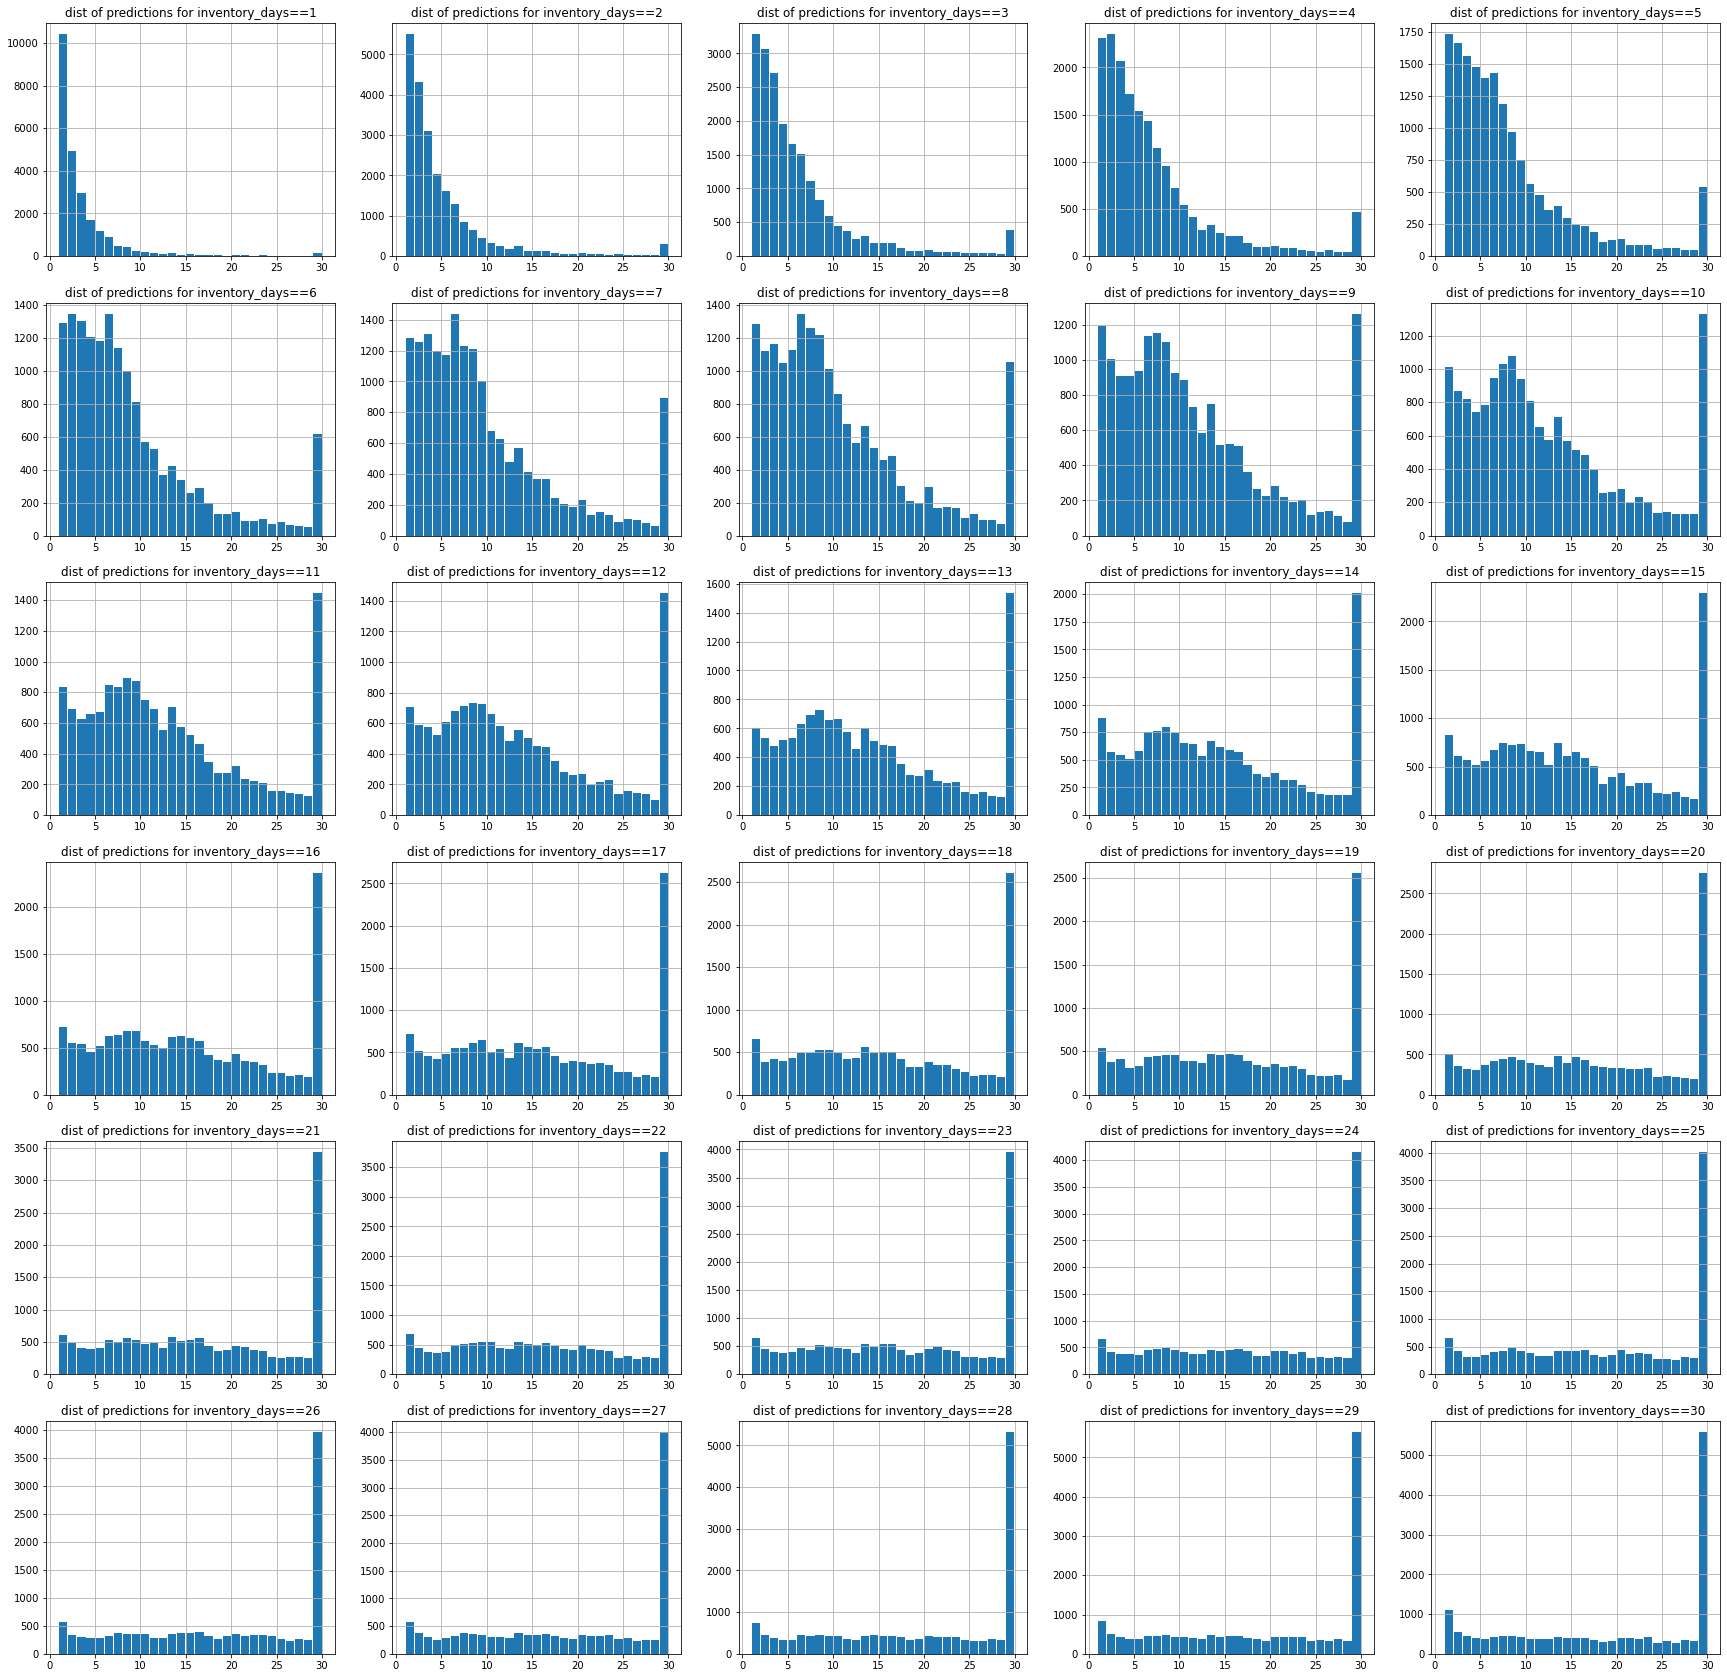

In [24]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("inventory_days <= 31").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").median() )
    print()
    
    plt.figure(figsize=(20,5))
    plt.hist(
        [valid.query("inventory_days <= 31").inventory_days, 
         valid.query("inventory_days <= 31").days_to_stockout,
        ],
        label=["target","predictions"],
        bins=np.arange(1,31,1),
        align="right",
        rwidth=0.8)
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("days_to_stockout_disc==@d").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of targets for days_to_stockout_disc=={d}")
        plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("inventory_days==@d").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of predictions for inventory_days=={d}")
        plt.grid()
    plt.show()

RMSE (mean):  8.933306129717964
MAE (mean):  6.669664334943073
MAE (median):  4.980187903144611



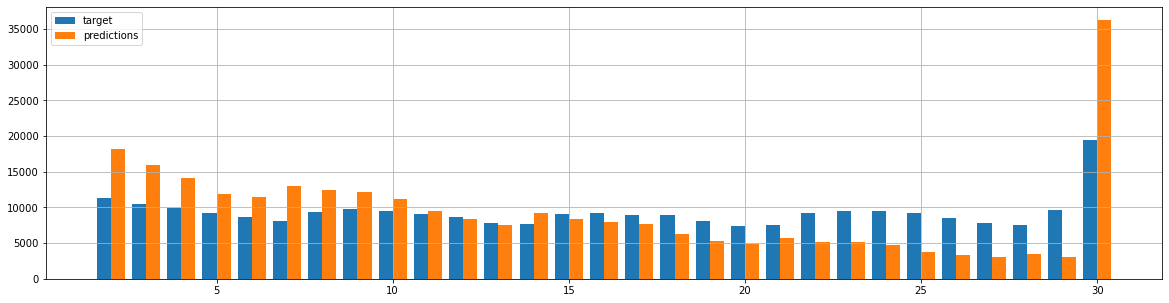

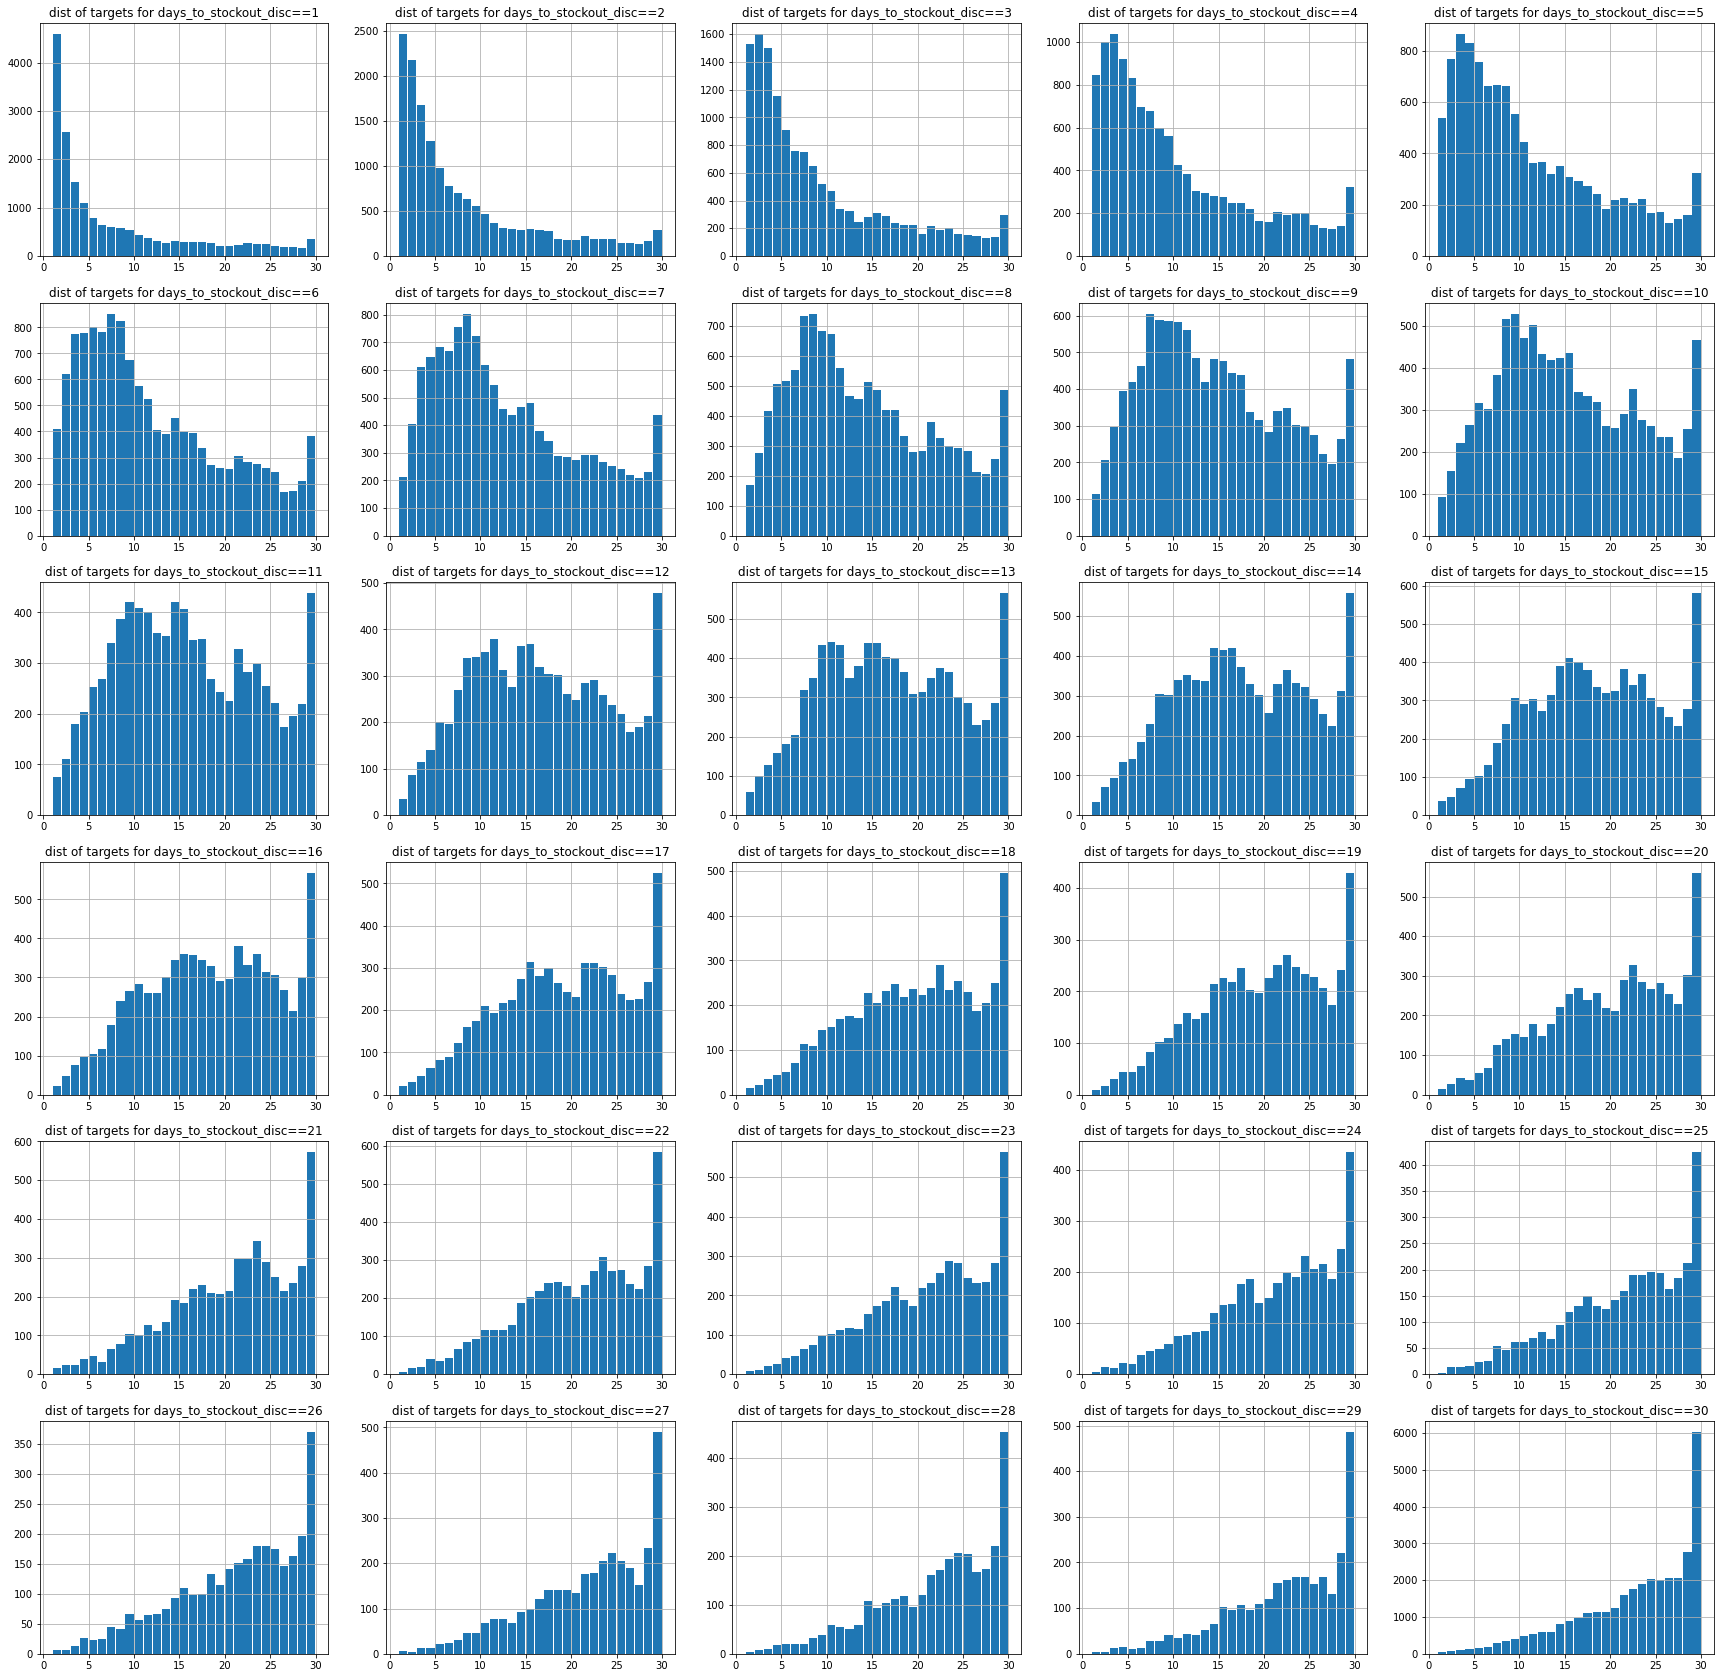

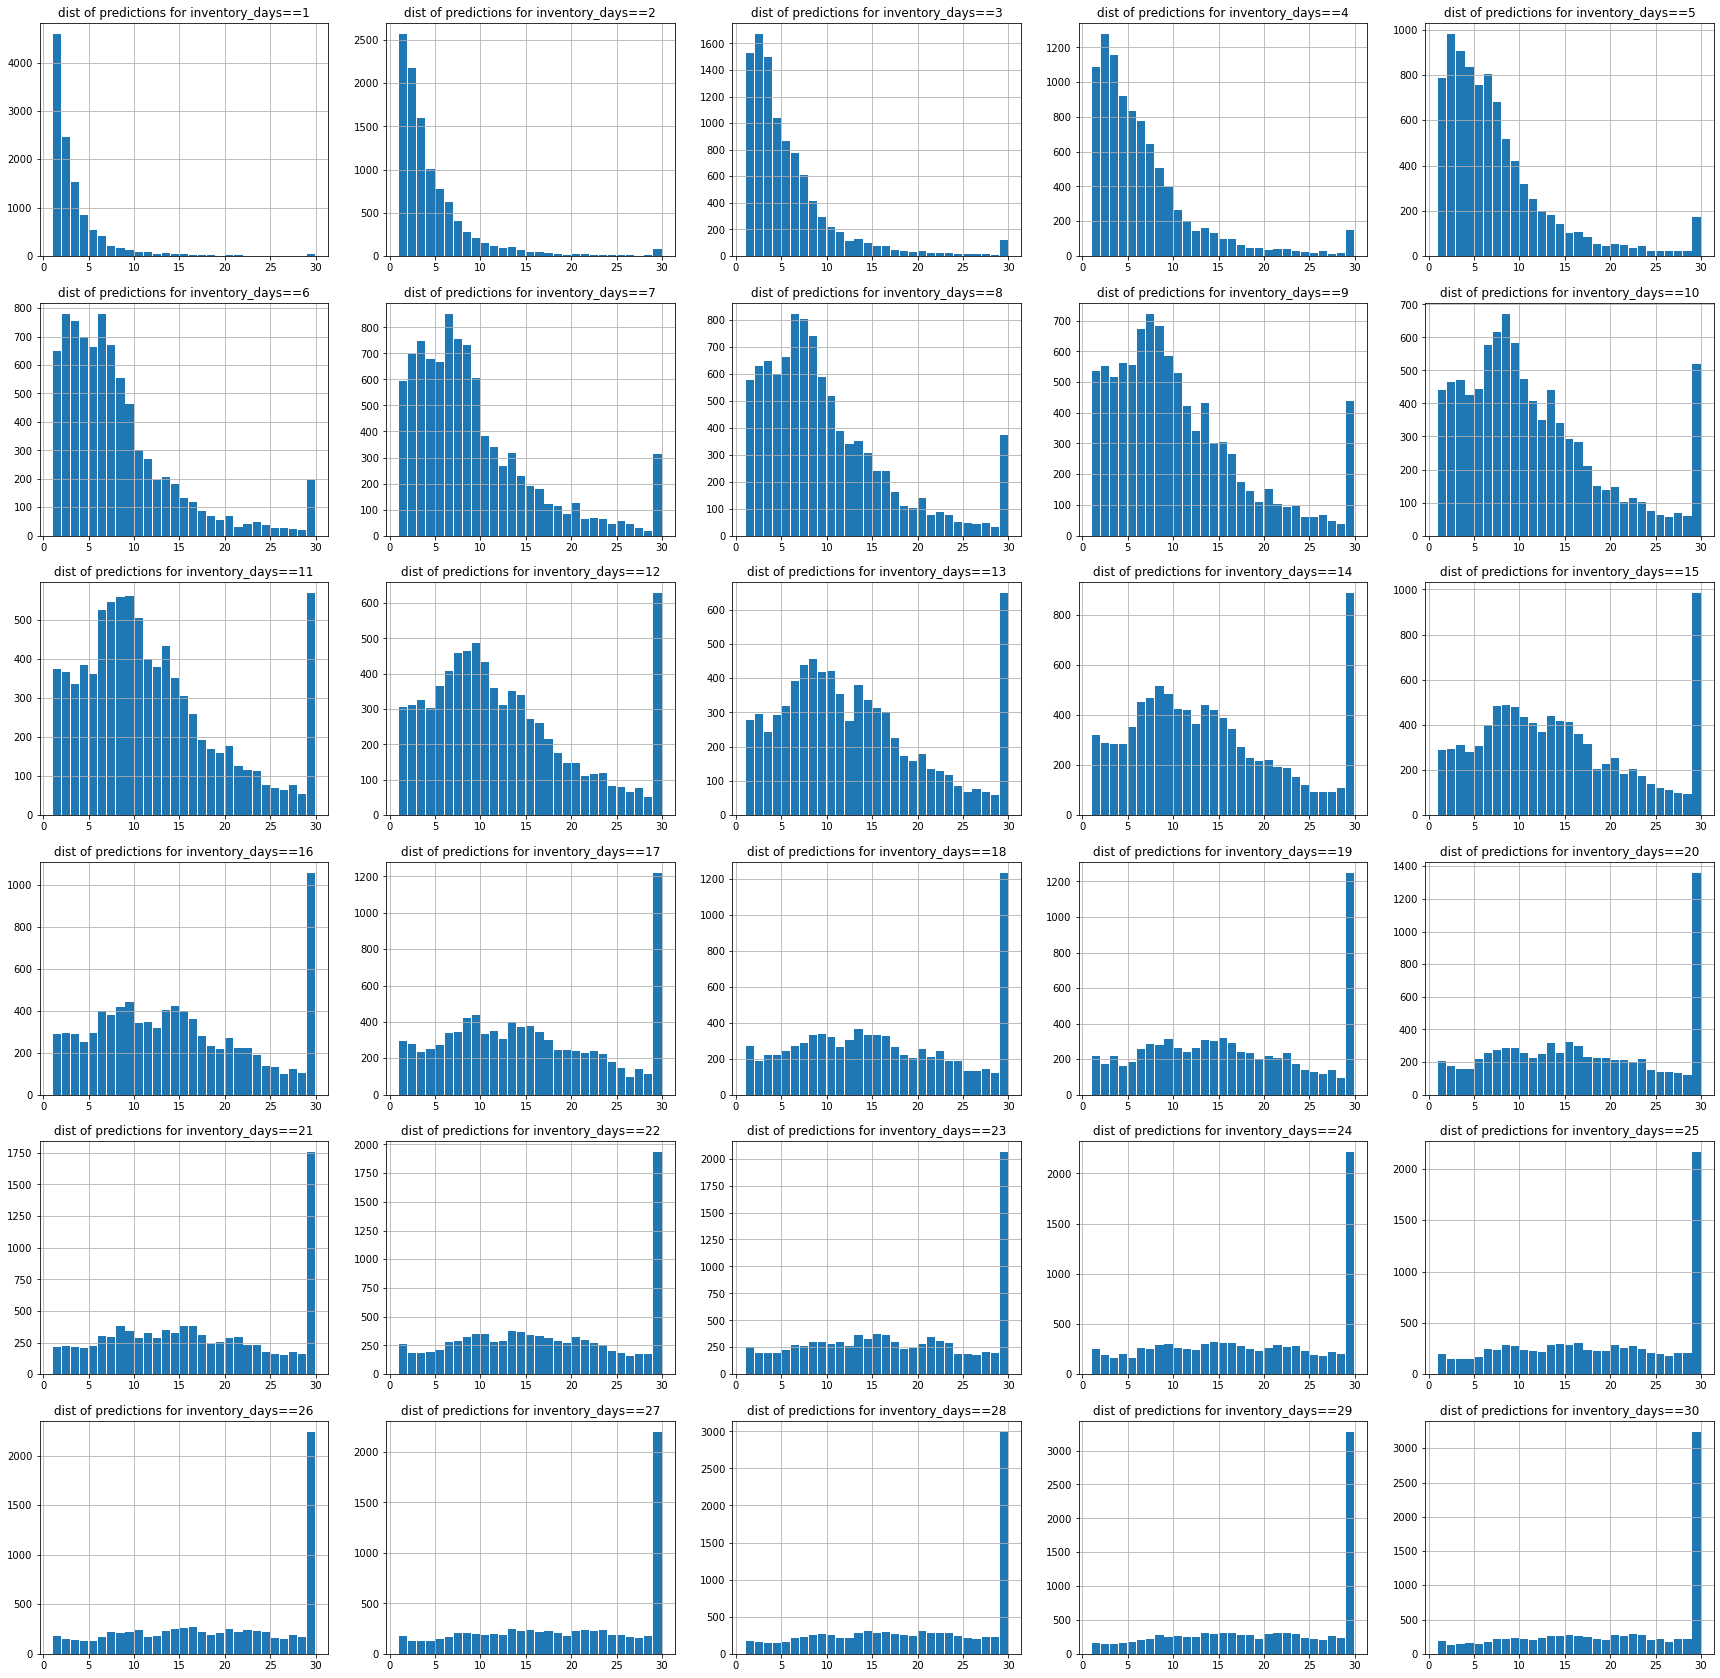

In [25]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("sku in @skus_assess_m2").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").median() )
    print()
    
    plt.figure(figsize=(20,5))
    plt.hist(
        [valid.query("sku in @skus_assess_m2").inventory_days, 
         valid.query("sku in @skus_assess_m2").days_to_stockout,
        ],
        label=["target","predictions"],
        bins=np.arange(1,31,1),
        align="right",
        rwidth=0.8)
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("(days_to_stockout_disc == @d) & (sku in @skus_assess_m2)").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of targets for days_to_stockout_disc=={d}")
        plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("(inventory_days == @d) & (sku in @skus_assess_m2)").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of predictions for inventory_days=={d}")
        plt.grid()
    plt.show()

***
## Assessment of RPS

In [28]:
if ASSESS:
    valid_files = [fn for fn in glob(f"{input_path}/validation_*.csv") if ("seed23" in fn or "real" in fn)]
    results = list()

    for files in valid_files:
        valid = (
            pd.read_csv(files)
            .query("sku in @skus_assess_m1")
            .query("inventory_days <= 30")
            .reset_index(drop=True)
        )
        valid["inventory_days"] = valid["inventory_days"].astype(int)
        
        preds_proba = list()
        for sku,df in tqdm(valid.groupby("sku")):
            preds_proba.append(predictor.predict_proba(
                sku, 
                stock=df.target_stock.values[0],
                lambda1=dist_config["lambda1"], 
                lambda2=dist_config["lambda2"],
                lambda3=dist_config["lambda3"],
                lambda4=dist_config["lambda4"],
            ))
        preds_proba = np.array(preds_proba)

        rps = scoring_function(valid.inventory_days.values, preds_proba)
        results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
        print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 482635/482635 [03:07<00:00, 2569.20it/s]


{'file': 'validation_seed23_harder', 'rps': 4.383575404969904}


100%|██████████| 482635/482635 [03:08<00:00, 2558.80it/s]


{'file': 'validation_seed23', 'rps': 4.136446527585724}


100%|██████████| 324347/324347 [02:07<00:00, 2541.16it/s]


{'file': 'validation_realstock', 'rps': 3.9263173766385346}


In [29]:
if ASSESS:
    display(pd.DataFrame(results))

,file,rps
0,validation_seed23_harder,4.383575
1,validation_seed23,4.136447
2,validation_realstock,3.926317


In [30]:
if ASSESS:
    # cleanup ram
    del models_by_site
    gc.collect()

***
## model training

In [31]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values

dataset = (
    pd.read_parquet(f"{input_path}/train-m1.parquet")
    .query("sku not in @unpredictable.sku")
    .query("sku in @skus_for_test")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

with open("../encoders/encoder-stg2.dill", "rb") as file:
    encoder = dill.load(file)
    file.close()

transformed = encoder.transform(dataset[encoder.cols].astype("category"))
for col in transformed.columns:
    dataset[col+"_glm"] = transformed[col].values

nrows: 30.218397
nskus: 526158


In [32]:
test = (
    pd.read_parquet(f"{input_path}/test-m1.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

transformed = encoder.transform(test[encoder.cols].astype("category"))
for col in transformed.columns:
    test[col+"_glm"] = transformed[col].values

nrows: 15.78474
nskus: 526158


In [33]:
raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")

# compute q_mean and q_std features (w/o leakage)
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-31")
dataset = feat.transform(dataset)
test = feat.transform(test)

In [34]:
# remove features built for the SM approach
dataset.drop([
    "item_domain_id_glob",
    "item_domain_id_glob_glm",
    "product_id_glob",
    "product_id_glob_glm",
    "product_family_id_glob",
    "product_family_id_glob_glm",
    ],
    axis=1,
    inplace=True
)

In [35]:
min_weight = 0.1
scaler = preprocessing.MinMaxScaler(feature_range=(min_weight, 1))
dataset["weight"] = scaler.fit_transform(dataset["minutes_active"].values.reshape(-1,1)).ravel()

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 237.55 Mb (48.4% reduction)
Elapsed time for processing features: 0.22414665222167968 min.
[LightGBM] [Info] Total Bins 10763
[LightGBM] [Info] Number of data points in the train set: 2621973, number of used features: 18


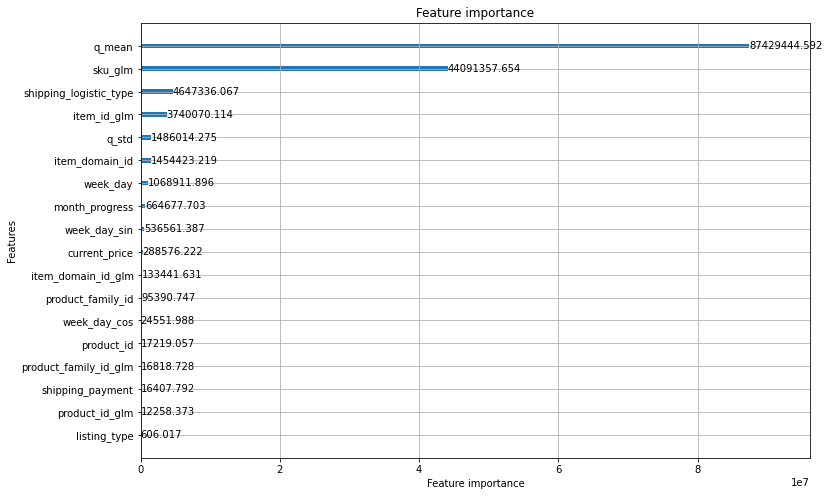

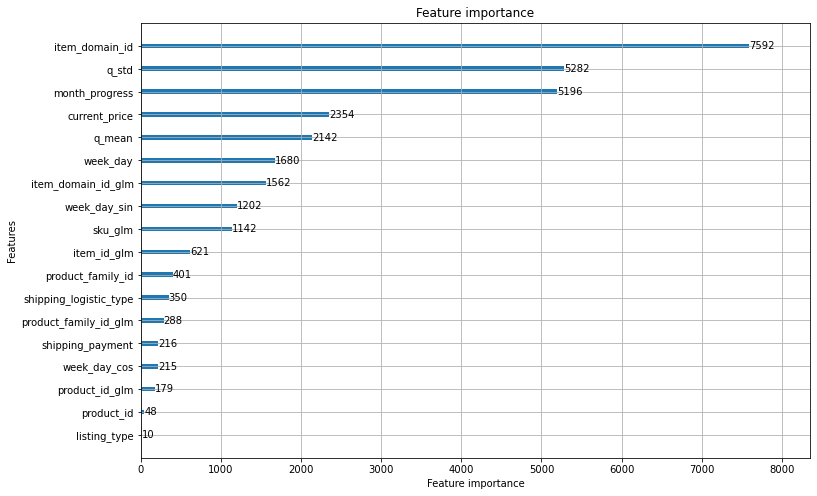

Elapsed time for training the model: 0.3725568413734436 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 1431.64 Mb (47.3% reduction)
Elapsed time for processing features: 1.2966583530108133 min.
[LightGBM] [Info] Total Bins 17732
[LightGBM] [Info] Number of data points in the train set: 15476171, number of used features: 18


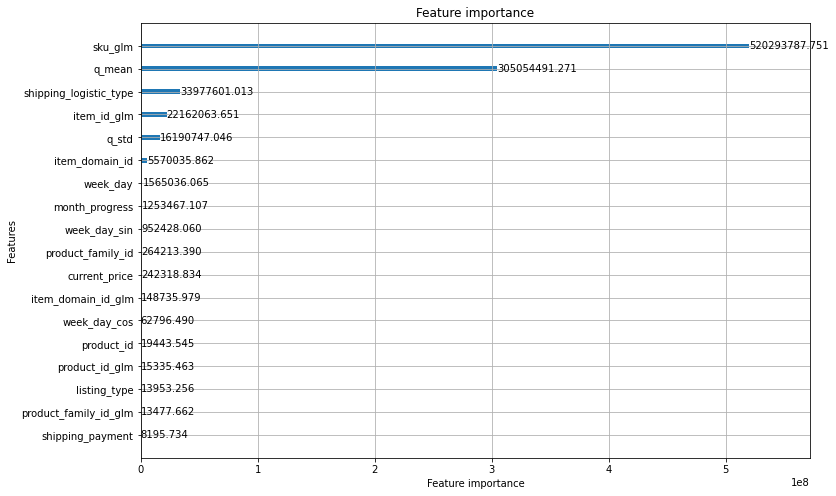

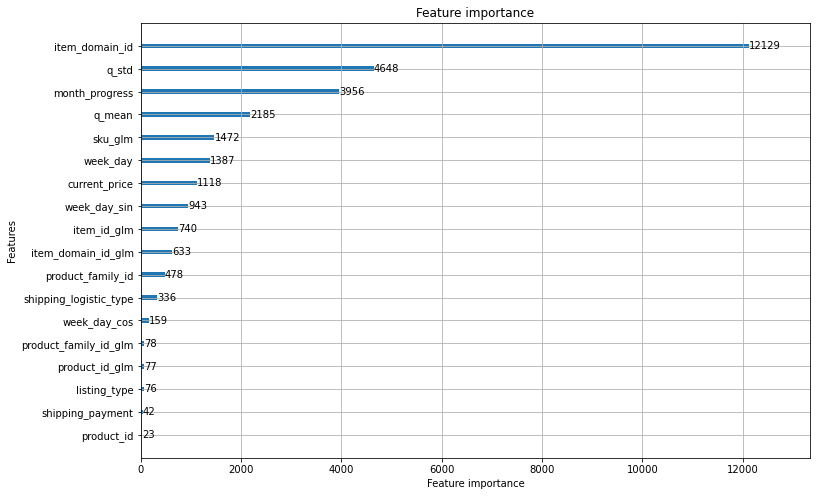

Elapsed time for training the model: 1.9518655379613241 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 1098.08 Mb (48.4% reduction)
Elapsed time for processing features: 1.334808870156606 min.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Total Bins 15298
[LightGBM] [Info] Number of data points in the train set: 12120253, number of used features: 18


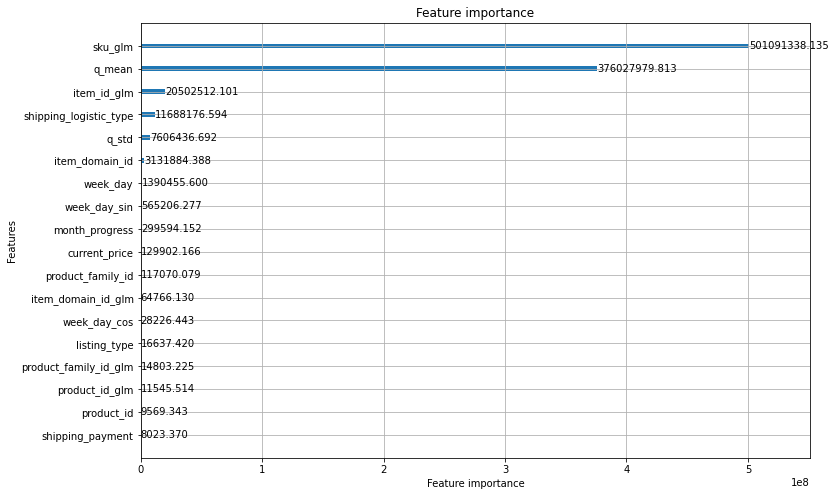

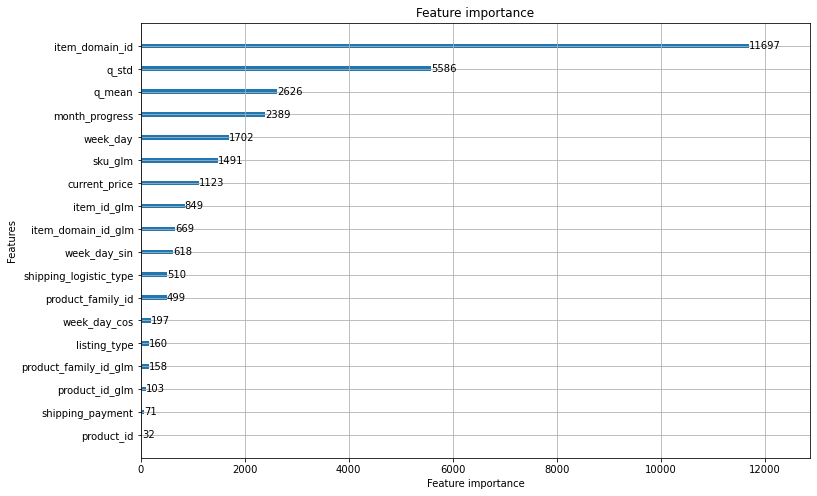

Elapsed time for training the model: 1.5523150245348611 min.


In [36]:
models_by_site = list()
sites = [
    "MLA",
    "MLB",
    "MLM",
]
num_iterations = {
    "MLA": 120,
    "MLB": 120,
    "MLM": 120,
}

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    
    _model_kwargs = dict(model_kwargs)
    _model_kwargs["model_params"]["num_iterations"] = num_iterations[site]

    model = LightGBMForecaster(**_model_kwargs)
    model.prepare_features(train_data)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit()
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [38]:
# compute predictions on test period
test["weight"] = None
preds_by_site = list()

for site,model in tqdm(zip(sites,models_by_site)):
    preds = model.predict(test.query("site_id == @site"), recursive=False)
    preds_by_site.append(preds)
    
predictions = pd.concat(preds_by_site, ignore_index=True)
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}.csv", index=False)

3it [02:07, 42.65s/it]


In [39]:
predictor = InventoryDaysPredictor(dataset)
predictor.fit(predictions)

100%|██████████| 526158/526158 [01:34<00:00, 5564.02it/s]


In [40]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])


100%|██████████| 526158/526158 [01:39<00:00, 5262.29it/s]


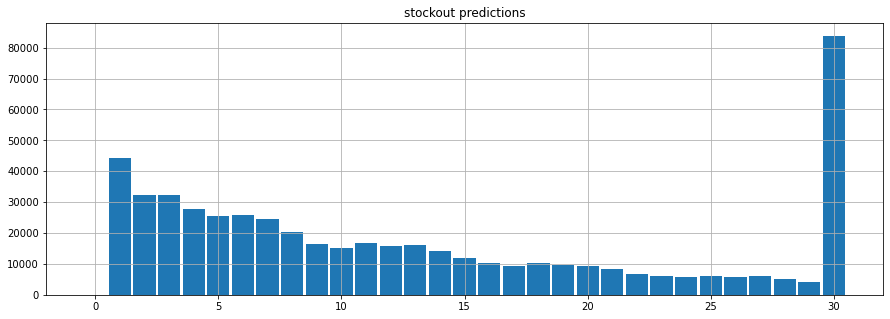

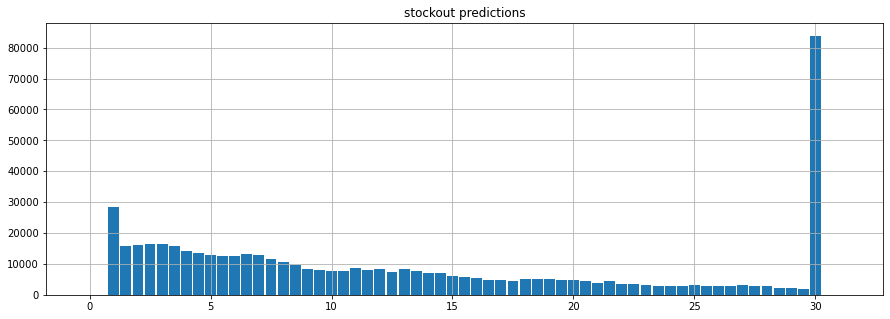

In [41]:
plt.figure(figsize=(15,5))
plt.hist(stockout_preds.days_to_stockout, bins=np.arange(0,32,1), rwidth=0.9, align='left')
plt.grid()
plt.title("stockout predictions")
plt.show()

plt.figure(figsize=(15,5))
plt.hist(stockout_preds.days_to_stockout, bins=np.arange(0,32,0.5), rwidth=0.9, align='left')
plt.grid()
plt.title("stockout predictions")
plt.show()

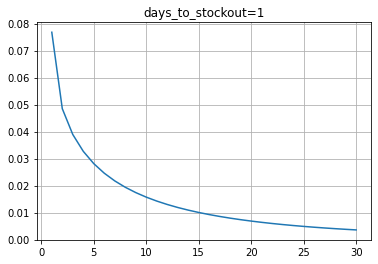

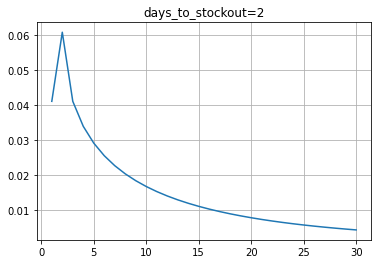

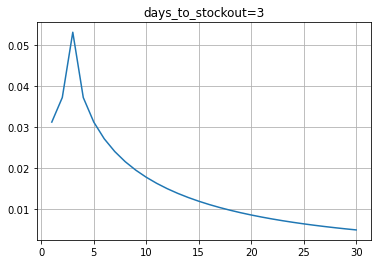

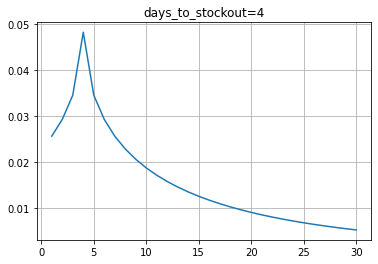

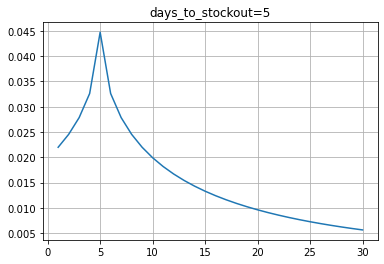

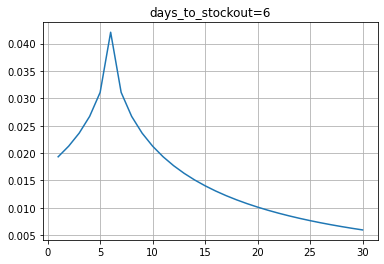

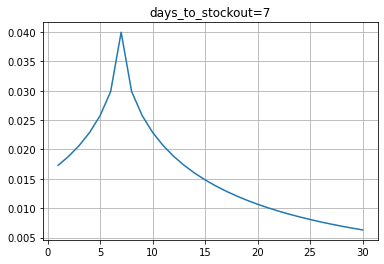

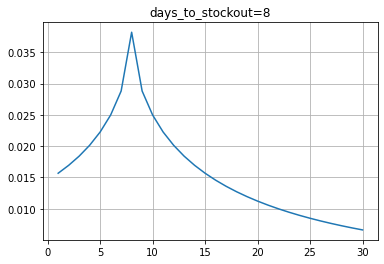

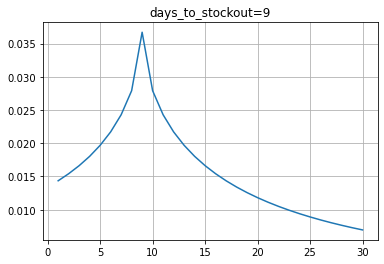

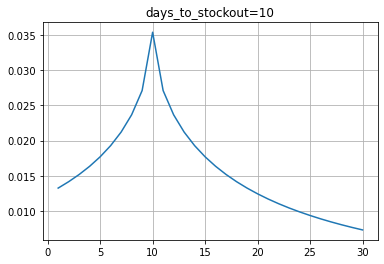

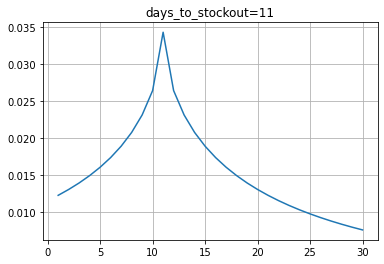

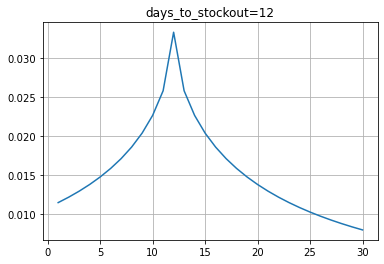

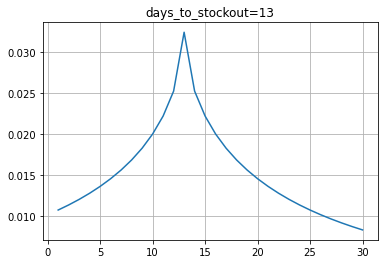

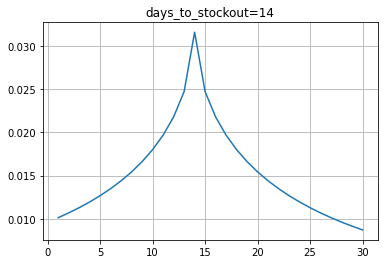

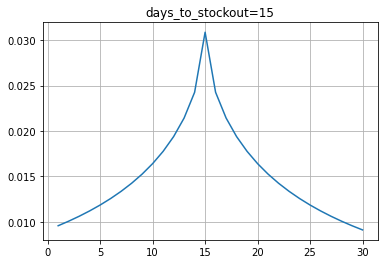

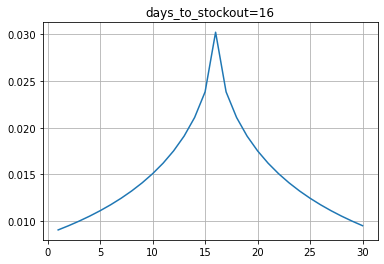

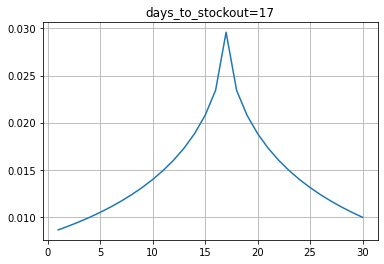

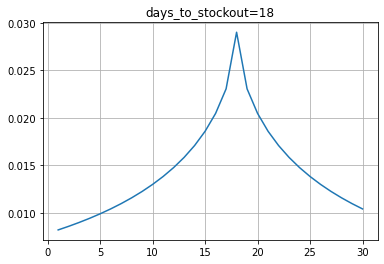

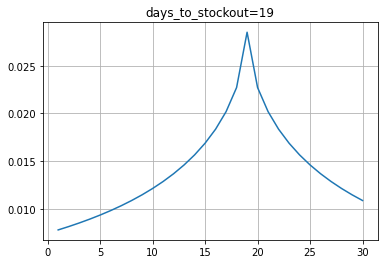

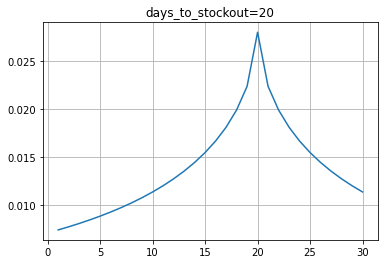

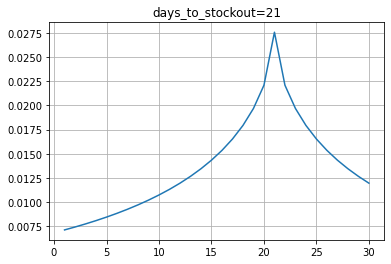

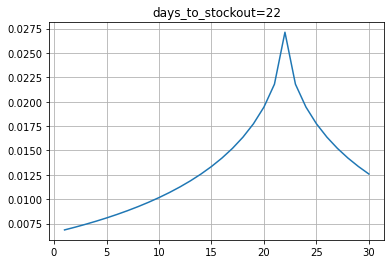

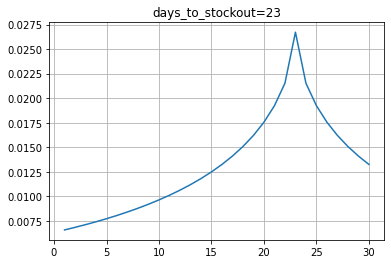

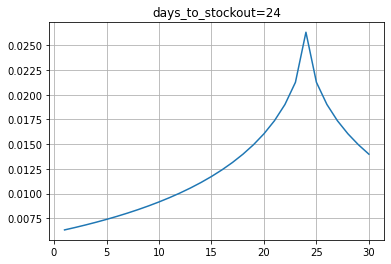

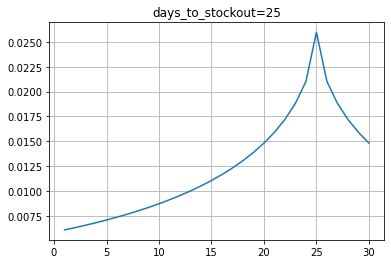

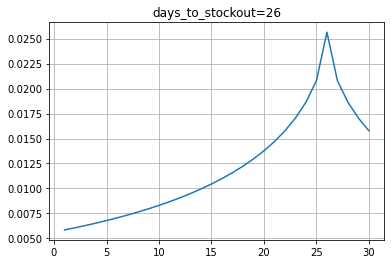

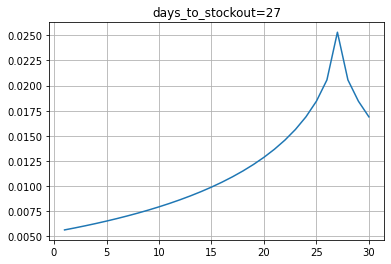

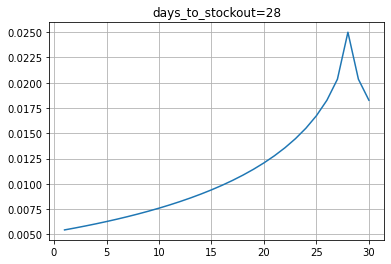

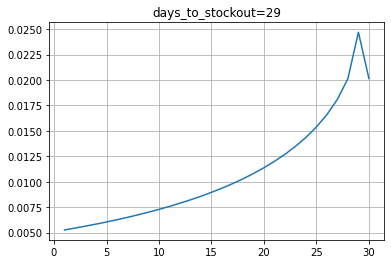

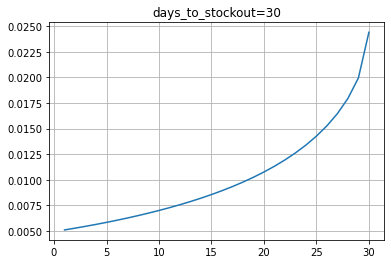

In [42]:
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (dist_config["lambda1"]*(days_to_stockout**dist_config["lambda2"]))
    beta = dist_config["lambda3"]*(days_to_stockout**dist_config["lambda4"])
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=beta)
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [43]:
# skus = list()
# preds_proba = list()
# groups = (
#     test[["sku","target_stock"]]
#     .drop_duplicates()
#     .groupby("sku")
# )

# for sku,df in tqdm(groups):
#     skus.append(sku)
#     preds_proba.append(predictor.predict_proba(
#         sku, 
#         stock=df.target_stock.values[0],
#         lambda1=dist_config["lambda1"], 
#         lambda2=dist_config["lambda2"],
#         lambda3=dist_config["lambda3"],
#         lambda4=dist_config["lambda4"],
#     ))
# preds_proba = np.array(preds_proba)
# preds_proba = pd.DataFrame(preds_proba, index=skus)

In [44]:
# unpreds_proba = np.ones((len(unpredictable),30)) / 30
# unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

# preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
# preds_proba_mrg

***
## generate submission

In [45]:
# test = pd.read_csv(f"{input_path}/test_data.csv")
# preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [46]:
# assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
# assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
# assert preds_proba_mrg.max(axis=1).max() < 1

In [47]:
# (preds_proba_mrg
#  .round(4)
#  .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
# )

***